In [5]:
# Install required packages in the current Jupyter kernel
# Uncomment the following lines if you need to install these libraries
# If you run into permission issues, try with the --user option
#import sys
#!pip install -q rdflib networkx matplotlib
#!{sys.executable} -m pip install rdflib networkx matplotlib pandas stringdb --user


In [6]:
%load_ext autoreload
%autoreload 2
import sampler
import grabhogs_sparql
import map2string_fast
import addfrombloom
import rdflib
import SPARQLWrapper
import colour
import itertools
import networkx as nx
import glob
from matplotlib import pyplot as plt

In [7]:
datapath = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.links.rdf.v11.5/402676.protein.links.rdf.v11.5.txt.gz'
# RDF graph loading
rg = sampler.load_graph(datapath)

datapath2 = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.info.rdf.v11.5/402676.protein.info.rdf.v11.5.txt.gz'
# RDF graph loading
rg_info  = sampler.load_graph(datapath2)

rdflib Graph loaded successfully with 2620310 triples
rdflib Graph loaded successfully with 14559 triples


In [8]:
links = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.links.rdf.v11.5/*.protein.links.rdf.v11.5.txt.gz'
linkfiles = glob.glob(links)
linkfiles = { l:{ 'links':l , 'info':l.replace('protein.links' , 'protein.info' ) } for l in linkfiles}
print(len(linkfiles ))

1831


In [9]:
subjs = rg.subjects( unique = True)
seed = next(subjs)
print(seed)

https://string-db.org/network/402676.B6K3U2


In [10]:
subg = sampler.sample( rg = rg , seed = seed,  layer_limit= 2 , sample_run = 20 )
print(set([p for p in subg.predicates()]))
print("rdflib Graph sampled successfully with {} triples".format(len(subg)))



176 654
{rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/any-confidence')}
rdflib Graph sampled successfully with 528 triples


[rdflib.term.URIRef('https://string-db.org/rdf/any-confidence'), rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff')]
{rdflib.term.URIRef('https://string-db.org/rdf/any-confidence'): '#ff0000', rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'): '#aaff00', rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'): '#00ffaa', rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff'): '#0000ff'}


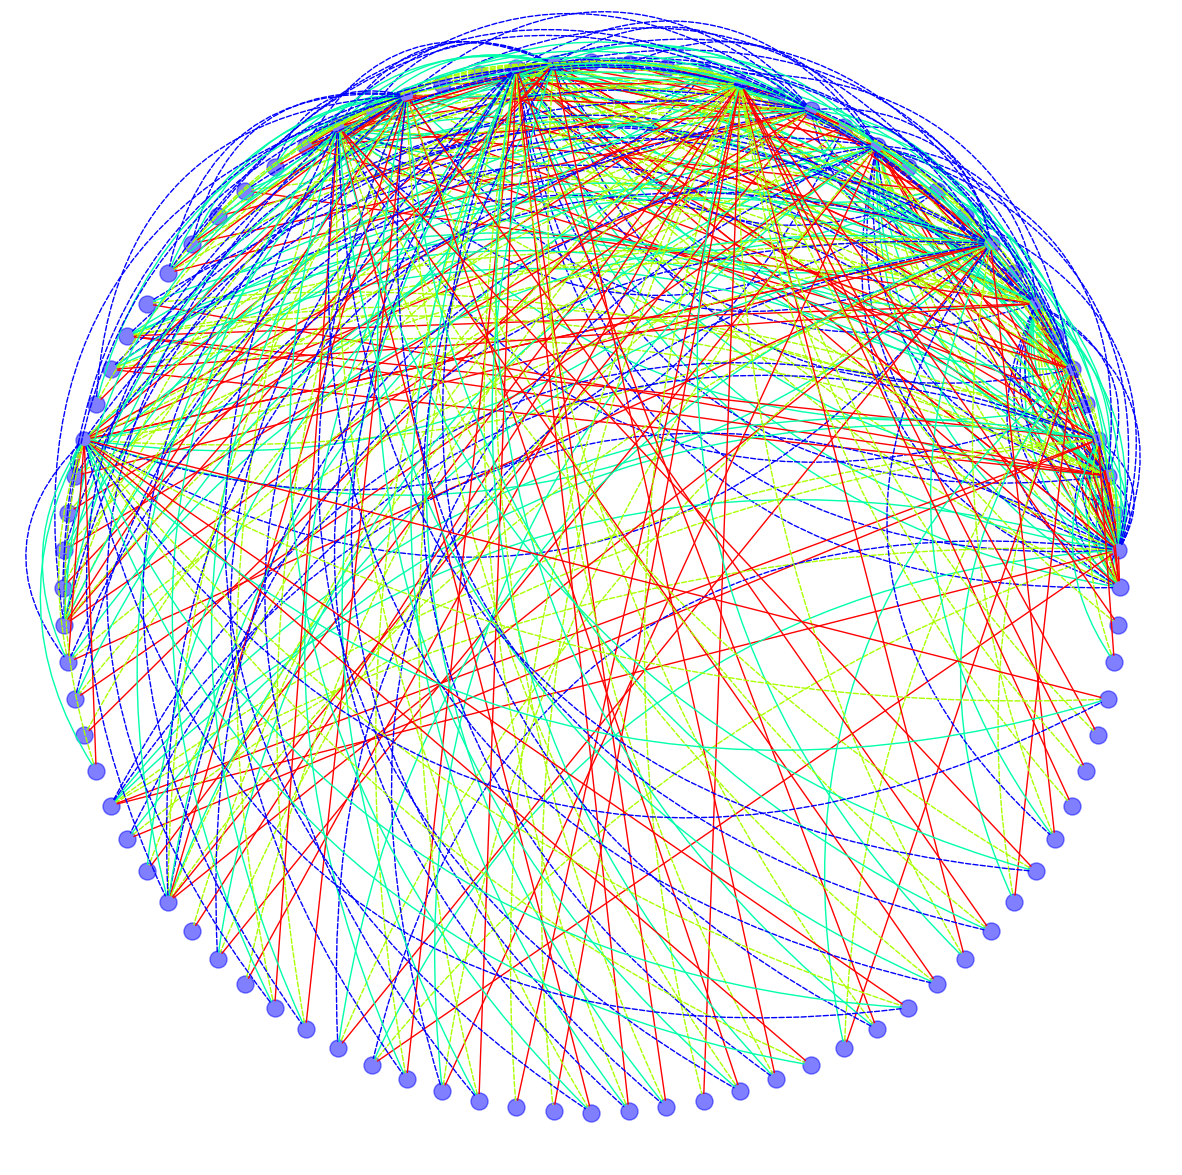

In [11]:
import colour
import itertools

preds = rg.predicates(subject=None, object=None, unique=True)
preds = [ p for  p in preds]
print(preds)

G = rdflib.extras.external_graph_libs.rdflib_to_networkx_multidigraph( subg , lambda s, p, o: {'data':{'key':p  , 'weight':1} } )


red = colour.Color('red')
blue = colour.Color('blue')

c = [ c.hex_l for c in  list(red.range_to(blue, len(preds))) ]
colors = { p:c[i] for i,p in enumerate(preds)}
delta = 2/len(preds)
curve = { p:delta*i for i,p in enumerate(preds) }
style = itertools.cycle([ '-', '--' ])
line_style = { p:next(style) for p in preds }
print(colors)
pos = nx.circular_layout( G )
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.plot()

#plot the whole mess
ax = plt.gca()

for e in G.edges(data = True):
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-", color=colors[e[2]['data']['key']],
                                shrinkA=5, shrinkB=5, lw = e[2]['data']['weight'], ls = line_style[e[2]['data']['key']],
                                patchA=None, patchB=None, alpha = e[2]['data']['weight'],
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*curve[e[2]['data']['key']])
                                ),
                                ),
                )

nx.draw_networkx_nodes(G, pos, node_color = 'b', node_size = 150, alpha = .5)
#labels=nx.draw_networkx_labels(G , pos = pos , font_size= 15 , font_color='w')

plt.axis('off')
plt.show()

In [12]:
subg = sampler.add_xrefs( rg_info , subg )
print("rdflib Graph annotated successfully with {} triples".format(len(subg)))
print(set([p for p in subg.predicates()]))
cross_ref = rdflib.term.URIRef("http://purl.org/lscr#xrefUniprot")
i = 0 
for s,p,o in subg.triples((None, cross_ref, None)):
    print(s,p,o)
    i+= 1
    if i > 10:
        break

88
88
rdflib Graph annotated successfully with 616 triples
{rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'), rdflib.term.URIRef('http://purl.org/lscr#xrefUniprot'), rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/any-confidence')}
https://string-db.org/network/402676.B6K4U7 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6K4U7
https://string-db.org/network/402676.B6JXI4 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6JXI4
https://string-db.org/network/402676.B6JXC0 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6JXC0
https://string-db.org/network/402676.B6JWP7 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6JWP7
https://string-db.org/network/402676.B6JWQ1 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6JWQ1
https://string-db.o

In [13]:
#proteins_by_species , results_subj_para , results_subj_ortho  = grabhogs_sparql.grab_hogs( subg , cross_ref = rdflib.term.URIRef("http://purl.org/lscr#xrefUniprot") )

In [14]:
#print(results_subj_ortho)

In [15]:
orthograph =  grabhogs_sparql.grab_hogs_graph( subg , cross_ref , sparql_endpoint= None
            , USE_CASE = 1 , verbose = True , cross_ref_prop = rdflib.term.URIRef("http://purl.org/lscr#xrefUniprot"))

88
Total time for 176 SPARQL queries: 210.22103571891785 seconds (multiple batch calls in: 0 cases)
Num errors: 0


In [16]:
from rdflib import Graph, URIRef
print("rdflib Graph annotated successfully with {} triples".format(len(orthograph)))
#get all species
taxa = [ 'protein1_uniprot_taxon_orth' , 'protein1_uniprot_taxon_para']
species = set( [ o for t in taxa  for s,p,o in orthograph.triples((None, URIRef(t), None))  ])


rdflib Graph annotated successfully with 1279313 triples


In [21]:
#get all the results for that species
taxa = [ 'orth_protein_uniprot_taxon_orth' , 'para_protein_uniprot_taxon_para']
#get all proteins for each species
prots_by_species = { spec: set([s  for s,p,o in orthograph.triples((None, URIRef(t), spec ))]) for t in taxa for spec in species  }
prots_by_species = { spec:prots_by_species[spec] for spec in prots_by_species if len(prots_by_species[spec])   }
prots_by_species = { spec:[ p.replace('http://purl.uniprot.org/uniprot/' , '' ) for p in prots_by_species[spec] ] for spec in prots_by_species }


In [22]:
server = 'dna066'
ortho_xrefgraph = map2string_fast.mapall(prots_by_species , serverurl= "http://"+server+":3030/string_fuseki/sparql" , retgraph = True)
print(len(ortho_xrefgraph))

NameError: name 'traceback' is not defined

In [ ]:
orthograph += ortho_xrefgraph
subg += orthograph
#we have interactions for one species and ortho info to all others

In [ ]:
filters = addfrombloom.load_filters()

In [18]:
import addfrombloom
import rdflib
pred = rdflib.term.URIRef('http://purl.org/lscr#xrefUniprot')
interactions = []
for i,spec in enumerate(prots_by_species):
    stringids = [ s for prot in prots_by_species[spec] for s,p,o in orthograph.triples((None, pred , URIRef('http://purl.uniprot.org/uniprot/'+prot) )) ]
    stringids = [ s.replace('https://string-db.org/network/' , '' ) for s in stringids ]
    before = len(interactions)
    if len(stringids ) > 2 :
        interactions += addfrombloom.check_allvall( objects = stringids , urlstring = 'https://string-db.org/network/' , filters = filters )
        if len(interactions)-before>0:
            print('found {} interactions for species {}'.format(len(interactions)-before , spec))
            print(len(subg))
            for inter in interactions:
                subg = subg.add( inter)
            print(len(subg))
            interactions = []
    if i % 10 == 0 :
        print('saving')
        v = subg.serialize(format="ttl")
        with open('testgraph_'+str(i)+'.ttl', 'w') as graphout:
            graphout.write(v)

NameError: name 'prots_by_species' is not defined

In [ ]:
#halelujah we have a graph with everything in it
#serialize to turtle format
v = subg.serialize(format="ttl")
with open('testgraph.ttl', 'w') as graphout:
    graphout.write(v)

In [1]:
#get a model
import NX2pyg
import buildmodel
import rdflib
import random
import glob

graphs = glob.glob('./test/*.ttl')
random.shuffle(graphs)
import NX2pyg
print(graphs ) 
readg = rdflib.Graph()
#load 1 sample to initialize a model
readg.parse('./test/tax_402676.B6JZZ0_seed_402676.ttl')
print(len(readg))
#set prediction link type

pred_s,pred_p,pred_o = ('ns6', '<https://string-db.org/rdf/high-confidence-cutoff>', 'ns6')
#load one heterodata sample
data , inputdims , interactions , node_index_by_type  = NX2pyg.rdf2hetero(readg)
print(data , inputdims , interactions )
#set final layer before linkpred size
outputdims = { t : 50 for t in inputdims }

['./test/tax_9606.ENSP00000307701_seed_9606.ttl', './test/tax_59689.fgenesh2_kg.3__1006__AT3G09820.1_seed_59689.ttl', './test/tax_59689.scaffold_802252.1_seed_59689.ttl', './test/tax_9606.ENSP00000360266_seed_9606.ttl', './test/tax_9606.ENSP00000329295_seed_9606.ttl', './test/tax_59689.fgenesh2_kg.4__551__AT2G26330.1_seed_59689.ttl', './test/tax_59689.Al_scaffold_0007_2742_seed_59689.ttl', './test/tax_9031.ENSGALP00000013608_seed_9031.ttl', './test/tax_59689.fgenesh2_kg.1__1616__AT1G14750.1_seed_59689.ttl', './test/tax_9031.ENSGALP00000000419_seed_9031.ttl', './test/tax_402676.B6K6T8_seed_402676.ttl', './test/tax_9606.ENSP00000310861_seed_9606.ttl', './test/tax_59689.scaffold_701161.1_seed_59689.ttl', './test/tax_59689.fgenesh2_kg.5__360__AT3G26060.1_seed_59689.ttl', './test/tax_402676.B6JZZ0_seed_402676.ttl', './test/tax_59689.fgenesh2_kg.5__2757__AT3G62670.1_seed_59689.ttl', './test/tax_59689.fgenesh2_kg.1__1697__AT1G15420.1_seed_59689.ttl', './test/tax_59689.scaffold_300885.1_seed_5

In [4]:
#init model
model = buildmodel.HeteroGCN_linkpred( linkpred = (pred_s,pred_p,pred_o) , inpudims= inputdims, interactions = interactions , outputdims= outputdims , dropout = .2 , layers = [10,10,10 ,10, 10 , 10, 10 ] , tan_final = True)
print(model)

hidden units 10
layer 0
hidden units 10
layer 1
hidden units 10
layer 2
hidden units 10
layer 3
hidden units 10
layer 4
hidden units 10
layer 5
hidden units 10
layer 6
HeteroGCN_linkpred(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=64)
    (1): HeteroConv(num_relations=64)
    (2): HeteroConv(num_relations=64)
    (3): HeteroConv(num_relations=64)
    (4): HeteroConv(num_relations=64)
    (5): HeteroConv(num_relations=64)
    (6): HeteroConv(num_relations=64)
  )
  (lins): ModuleDict(
    (ns3): Linear(-1, 10, bias=True)
    (ns4): Linear(-1, 10, bias=True)
    (ns5): Linear(-1, 10, bias=True)
    (ns6): Linear(-1, 10, bias=True)
  )
  (lins2): ModuleDict(
    (ns3): Linear(-1, 50, bias=True)
    (ns4): Linear(-1, 50, bias=True)
    (ns5): Linear(-1, 50, bias=True)
    (ns6): Linear(-1, 50, bias=True)
  )
  (classifier): Classifier()
)


In [ ]:
#train
import torch
import tqdm
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader
import torch.nn.functional as F
import torch

from sklearn.metrics import roc_auc_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = model.to(device)
lastauc = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
for subgraph in graphs[0:5]:
    print('learning from ' , subgraph)
    readg = rdflib.Graph()
    readg.parse(subgraph)
    data , inputdims , interactions , node_index_by_type  = NX2pyg.rdf2hetero(readg)
    if pred_s == pred_o:
        revpred = (pred_s,pred_p,pred_o)
    else:
        revpred  = pred_o, 'rev_'+pred_p,pred_s
    transform = T.RandomLinkSplit(
        num_val=0.1,  # percentage of VALIDATION
        num_test=0.1,  # percentage of TESTING
        disjoint_train_ratio=0.3,  # this somehow has to do with the 30% we need for supervision
        neg_sampling_ratio=2,  # TODO
        add_negative_train_samples=True,  # TODO
        edge_types=(pred_s,pred_p,pred_o),
        rev_edge_types=(pred_s,pred_p,pred_o), 
    )
    train_data, val_data, test_data = transform(data)
    # Define seed edges:
    edge_label_index = train_data[pred_s,pred_p,pred_o].edge_label_index
    edge_label = train_data[pred_s,pred_p,pred_o].edge_label
    train_loader = LinkNeighborLoader(
        data=train_data,  # TODO
        num_neighbors=[50, 50 , 50],  # TODO
        edge_label_index=((pred_s,pred_p,pred_o), edge_label_index),
        #edge_label=edge_label,
        neg_sampling_ratio=2,  # TODO
        batch_size=1000,
        shuffle=True
    )
    
    test_edge_label_index = test_data[pred_s,pred_p,pred_o].edge_label_index
    test_edge_label = test_data[pred_s,pred_p,pred_o].edge_label
    testloader = LinkNeighborLoader(
        data=test_data,  # TODO
        num_neighbors=[50, 50 , 50],  # TODO
        edge_label_index=((pred_s,pred_p,pred_o), test_edge_label_index),
        #edge_label=edge_label,
        neg_sampling_ratio=2,  # TODO
        batch_size=100,
        shuffle=True
    )
    model.train()

    for epoch in range(1, 100):
        total_loss = total_examples = 0
        for sampled_data in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            sampled_data = sampled_data.to(device)
            pred = model.forward(sampled_data )
            loss = F.binary_cross_entropy_with_logits(pred , sampled_data[pred_s,pred_p,pred_o].edge_label)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * pred.numel() # numel = number of elements
            total_examples += pred.numel()
        if epoch%10 == 0:
            model.eval()
            for sampled_data in tqdm.tqdm(testloader):
                sampled_data = sampled_data.to(device)
                pred = model.forward(sampled_data)
                true = sampled_data[pred_s,pred_p,pred_o].edge_label
                auc = roc_auc_score(true.cpu().numpy(), pred.detach().numpy())
                if auc > lastauc:
                    torch.save(model, 'model.torch')
            model.train()
        print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'
learning from  ./test/tax_9606.ENSP00000307701_seed_9606.ttl


In [15]:
#pred  and validate for one validation set
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt


val_loader = LinkNeighborLoader(
    data=val_data,  # TODO
    num_neighbors=[50, 50 , 50],  # TODO
    edge_label_index=((pred_s,pred_p,pred_o), edge_label_index),
    #edge_label=edge_label,
    neg_sampling_ratio=2,  # TODO
    batch_size=1000,
    shuffle=True
)

preds = []
ground_truths = []
model.eval()
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        # TODO: Collect predictions and ground-truths and write them into
        # `preds` and `ground_truths`.
        sampled_data = sampled_data.to(device)
        print(sampled_data)
        pred = model.forward(sampled_data)
        preds += [pred]
        
        ground_truths += [sampled_data[pred_s,pred_p,pred_o].edge_label]
        index = sampled_data[pred_s,pred_p,pred_o].edge_label_index.cpu().numpy()
        pred = pred.cpu().numpy()[index]
        true = sampled_data[pred_s,pred_p,pred_o].edge_label.cpu().numpy()
        print(true.shape)
        print(pred.shape)
        auc = roc_auc_score(true, pred)


pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)

print()
print(f"Validation AUC: {auc:.4f}")

  0%|          | 0/12 [00:00<?, ?it/s]/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/ML2/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  0%|          | 0/12 [00:00<?, ?it/s]

HeteroData(
  ns3={ x=[34840, 1] },
  ns4={ x=[30971, 1] },
  ns5={ x=[656, 1] },
  ns6={ x=[5080, 1] },
  (ns3, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_uniprot_orth_protein_uniprot>, ns3)={ edge_index=[2, 9843] },
  (ns3, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_uniprot_para_protein_uniprot>, ns3)={ edge_index=[2, 14538] },
  (ns3, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_uniprot_orth_protein>, ns4)={ edge_index=[2, 1367] },
  (ns3, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_uniprot_para_protein>, ns4)={ edge_index=[2, 6581] },
  (ns3, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/para_protein_uniprot_taxon_para>, ns5)={ edge_index=[2, 13720] },
  (ns3, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2net

IndexError: index 4608 is out of bounds for axis 0 with size 4113

In [ ]:

from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(ground_truth, pred)
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]] , c = 'black' , linestyle='dashed')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(ground_truth, pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
#generate predictions by taking an all v all of each species subnet

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
from torch_geometric.nn import GCNConv

dataset = 'Cora'
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Planetoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True),
])
dataset = Planetoid(path, dataset, transform=transform)
train_data, val_data, test_data = dataset[0]


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=-1)

    def forward(self, x, edge_index, edge_label_index):
        z = model.encode(x, edge_index)
        return model.decode(z, edge_label_index).view(-1)


model = GCN(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()

    out = model(train_data.x, train_data.edge_index,
                train_data.edge_label_index)
    loss = F.binary_cross_entropy_with_logits(out, train_data.edge_label)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_label_index).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        val_auc = test(val_data)
        test_auc = test(test_data)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
              f'Test: {test_auc:.4f}')

model_config = ModelConfig(
    mode='binary_classification',
    task_level='edge',
    return_type='raw',
)

# Explain model output for a single edge:
edge_label_index = val_data.edge_label_index[:, 0]

explainer = Explainer(
    model=model,
    explanation_type='model',
    algorithm=GNNExplainer(epochs=200),
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=model_config,
)
explanation = explainer(
    x=train_data.x,
    edge_index=train_data.edge_index,
    edge_label_index=edge_label_index,
)
print(f'Generated model explanations in {explanation.available_explanations}')

# Explain a selected target (phenomenon) for a single edge:
edge_label_index = val_data.edge_label_index[:, 0]
target = val_data.edge_label[0].unsqueeze(dim=0).long()

explainer = Explainer(
    model=model,
    explanation_type='phenomenon',
    algorithm=GNNExplainer(epochs=200),
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=model_config,
)
explanation = explainer(
    x=train_data.x,
    edge_index=train_data.edge_index,
    target=target,
    edge_label_index=edge_label_index,
)
available_explanations = explanation.available_explanations
print(f'Generated phenomenon explanations in {available_explanations}')